# Context-Aware Plagiarism Advisory Tool
Evelyn Yee (CS 329T Final Project)

# Poster:
![project poster](figures/poster.png)

# Project Proposal
- Domain: Education
- Goal: Build a system to advise instructors and provide evidence for/against plagiarism in student works.
    - Difficult false positives: critique, citing, reference
    - Difficult false negatives: paraphrasing, summary, misquoting/misattribution
- System:
    1. **Retrieve** relevant documents from the corpus (e.g. vector search, string matching)
    1. **Reason** over text+context documents with LLM (RAG)
    1. **Identify** textual relationships
        - Ground claims in passages from new document and context
    1. Confidence estimation?
- Trustworthiness Principles:
    - **Grounding:** Each claim in the plagiarism analysis references specific features of the student document and at least one of the context documents.
    - **Confidence:** Provide to users a report containing a) a combination of text heuristics (e.g. BLEU score) and b) an assessment from the LLM, ending with a single label of the text ("plagiarized," "related," or "unrelated")
provide LLM CoT transcript/trace, so that users can understand and self-assess the label.

- Data: [PlagBench](https://arxiv.org/abs/2406.16288v1) Eval Set (accessed directly from jooyoung lee, since the full dataset hasn't been publicly released yet)
    - 405 plagiarism pairs
        - 135 verbatim plagiarism
        - 135 paraphrasing plagiarism
        - 135 summarization plagiarism
    - 405 non-plagiarism, related document pairs
    
    I have partitioned the dataset into a 70/15/15 train/validation/test split, with each split having the same proportion of each plagiarism label (i.e. 16.67% verbatim, 16.67% paraphrasing, 16.67% summary, 50% negative).

TODO: PROMPT FOR A CONFIDENCE SCORE (COMPARE WITH LOGISTIC REGRESSION NUMERICAL CONFIDENCE) 

# Table of Contents
- [Utilities](#utilities)
    - [Global Imports](#global-imports)
    - [Set up Snowflake](#set-up-snowflake-session)
    - [Load Data](#load-data)
    - [Evaluation Metrics](#evaluation-metrics)
- [Our System](#our-system)
    - [Prompts](#grounded-chain-of-thought-reasoning)
    - [RAG Implementation](#generate-final-report)
- [Baselines](#baselines)
    - [Text Heuristics](#text-heuristics)
    - [Parametric Knowledge + CoT](#parametric-knowledge--cot)
    - [RAG + Direct Prompting](#rag--direct-answering)
- [Evaluation](#evaluation)
    - [Text Heuristics](#text-heuristics---eval)
    - [Parametric Knowledge + CoT](#parametric-knowledge--cot---eval)
    - [RAG + Direct Prompting](#rag--direct-answering---eval)
    - [RAG + CoT (Our final model)](#rag--cot---eval)
- [Results + Discussion](#results--discussion)



# Utilities
<a id='utilities'></a>

## imports

In [ ]:
# install relevant packages
# %pip install --upgrade trulens-core trulens-providers-openai trulens-providers-huggingface trulens-dashboard
# %pip install --upgrade trulens-connectors-snowflake==1.2.2
# %pip install --upgrade openai pandas tqdm snowflake scikit-learn nltk rouge-score numpy

In [ ]:
# import relevant packages
from datetime import timedelta
import itertools
import json
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
from rouge_score.rouge_scorer import RougeScorer
from sklearn.linear_model import LogisticRegression
import threading
from tqdm.notebook import tqdm
tqdm.pandas()

import chromadb
import chromadb.utils.embedding_functions as embedding_functions

from trulens.providers.openai import OpenAI as OpenAI_tl

import openai
from openai import OpenAI
openai.api_key = os.environ["OPENAI_API_KEY"]
OPENAI_MODELS = ['gpt-4o-mini-2024-07-18']

from snowflake.cortex import Complete
SNOWFLAKE_MODELS = ['gemma-7b',
'jamba-1.5-mini',
 'jamba-1.5-large',
 'jamba-instruct',
 'llama2-70b-chat',
 'llama3-8b',
 'llama3-70b',
 'llama3.1-8b',
 'llama3.1-70b',
 'llama3.1-405b',
 'llama3.2-1b',
 'llama3.2-3b',
 'mistral-large',
 'mistral-large2',
 'mistral-7b',
 'mixtral-8x7b',
 'reka-core',
 'reka-flash',
 'snowflake-arctic']

from tenacity import retry, stop_after_attempt, wait_exponential
import warnings
def warn_on_retry(retry_state):
    if retry_state.attempt_number > 1:
        seconds_since_start = retry_state.upcoming_sleep or 0.0
        # if retry_state.outcome.failed:
        #     print(f"Retrying due to: {retry_state.outcome.exception()}")
        print(f"Trying...{retry_state.outcome}... Attempt {retry_state.attempt_number} after {seconds_since_start:.2f} seconds")


## Set up Snowflake Session

In [ ]:
# credentials
user = os.getenv('SNOWFLAKE_USER')
password = os.getenv('SNOWFLAKE_PASS')
connection_params = {
    "account": "TMB89584",
    "user": user,
    "password": password,
    "role": "TRAINING_ROLE",
    "database": "CHIPMUNK_DB",
    "schema": "PLAGBENCH",
    "warehouse": "ANIMAL_TASK_WH",
}

# Create a Snowflake session
snowpark_session = Session.builder.configs(connection_params).create()

## Load Data

In [7]:
# Create a snowflake cursor object
cursor = snowflake_connection.cursor()

# train
# Define the SQL query to fetch the data
train_query = "SELECT * FROM CHIPMUNK_DB.PLAGBENCH.PLAGBENCH_TRAIN"
cursor.execute(train_query)
train = cursor.fetch_pandas_all()
train.rename(columns={'SUSP_DOC':'query', 'PLAGIARISM_TYPE':'expected_response'},
             inplace=True)
train['expected_response'] = train['expected_response'].fillna('NA')
# persist data in trulens database so we can fetch it from here in the future
session.add_ground_truth_to_dataset(
    dataset_name="plagbench_train",
    ground_truth_df=train,
    dataset_metadata={"split": "train"},
)
display(train.head())
print("train size:", train.shape)

# test
# Define the SQL query to fetch the data
test_query = "SELECT * FROM CHIPMUNK_DB.PLAGBENCH.PLAGBENCH_TEST"
cursor.execute(test_query)
test = cursor.fetch_pandas_all()
test.rename(columns={'SUSP_DOC':'query', 'PLAGIARISM_TYPE':'expected_response'},
             inplace=True)
test['expected_response'] = test['expected_response'].fillna('NA')
# persist data in trulens database so we can fetch it from here in the future
session.add_ground_truth_to_dataset(
    dataset_name="plagbench_test",
    ground_truth_df=test,
    dataset_metadata={"split": "test"},
)
display(test.head())
print("test size:", test.shape)

# valid
# Define the SQL query to fetch the data
valid_query = "SELECT * FROM CHIPMUNK_DB.PLAGBENCH.PLAGBENCH_VALID"
cursor.execute(valid_query)
valid = cursor.fetch_pandas_all()
valid.rename(columns={'SUSP_DOC':'query', 'PLAGIARISM_TYPE':'expected_response'},
             inplace=True)
valid['expected_response'] = valid['expected_response'].fillna('NA')
# persist data in trulens database so we can fetch it from here in the future
session.add_ground_truth_to_dataset(
    dataset_name="plagbench_valid",
    ground_truth_df=valid,
    dataset_metadata={"split": "valid"},
)
display(valid.head())
print("valid size:", valid.shape)

KeyboardInterrupt: 

In [ ]:
# source docs for retrieval
ground_truth = pd.concat([train, test, valid])

# check if source_docs table already in snowflake
try:
    source_docs = snowpark_session.read.table("CHIPMUNK_DB.PLAGBENCH.SOURCE_DOCS")
    source_docs_df = source_docs.to_pandas()
except:
    source_docs = ground_truth['SOURCE_DOC'].unique()
    # write source_docs to snowflake
    source_docs_df = pd.DataFrame(source_docs, columns=['content'])
    source_docs_df['id'] = source_docs_df.index
    snowpark_session.write_pandas(source_docs_df, table_name="SOURCE_DOCS",
                                  database="CHIPMUNK_DB", schema='PLAGBENCH', auto_create_table=True)
    source_docs = snowpark_session.read.table("CHIPMUNK_DB.PLAGBENCH.SOURCE_DOCS")
    source_docs_df = source_docs.to_pandas()


## Evaluation Metrics

In [ ]:
provider = OpenAI_tl(model_engine="gpt-4o-mini-2024-07-18",
                     api_key=os.getenv('OPENAI_API_KEY'))
provider.endpoint.pace.marks_per_second = 5
provider.endpoint.pace.seconds_per_period = 1
provider.endpoint.pace.seconds_per_period_timedelta = timedelta(seconds=1)
provider.endpoint.pace.__dict__.items()

dict_items([('marks_per_second', 5), ('seconds_per_period', 1), ('seconds_per_period_timedelta', datetime.timedelta(seconds=1)), ('mark_expirations', deque([])), ('max_marks', 60), ('last_mark', datetime.datetime(2024, 12, 2, 16, 59, 54, 486375)), ('lock', <unlocked _thread.lock object at 0x713de476d900>)])

### RAG Trio

In [ ]:
# Groundedness

@retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=1, max=10),before=warn_on_retry)
def groundedness(target, context, output):
    caller = provider.groundedness_measure_with_cot_reasons
    context_str = ''
    for i in range(len(context)):
        context_str += f'SOURCE DOCUMENT {i+1}: {context[i]}\n'
    context_str += f'TARGET DOCUMENT: {target}'
    criteria = f"Your goal is to assess the groundedness of the provided STATEMENT \
in regard to the provided SOURCE DOCUMENTs and the TARGET DOCUMENT. \
Each STATEMENT should be substantiated by evidence from the TARGET DOCUMENT or at least one of the SOURCE DOCUMENTs. \
For each STATEMENT, think step by step and then score it with 1 if the claim is substantiated by the documents and 0 if it is not."
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        warnings.filterwarnings('ignore', category=UserWarning) # ignore issue with filtering trivial statements
        try:
            return caller(source=context_str, statement=output, criteria=criteria, min_score_val=0, max_score_val=1)
        except Warning as e:
            print('error in groundedness:',e)
            return (np.nan,{'reasons': f'Warning: {e}'})

In [ ]:
# Answer Relevance

@retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=1, max=10),before=warn_on_retry)
def a_relevance(prompt, output):
    caller = provider.relevance_with_cot_reasons
    criteria = f"Your goal is to assess the relevance of the provided RESPONSE \
to the provided PROMPT, which is to identify whether plagiarism in the target (student) document. \
For each RESPONSE, think step by step and then score it with 1 if the claim is relevant to the task and 0 if it is not."
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        warnings.filterwarnings('ignore', category=UserWarning) # ignore issue with filtering trivial statements
        try:
            return caller(prompt, output, criteria=criteria, min_score_val=0, max_score_val=1)
        except Warning as e:
            print('error in answer relevance:',e)
            return (np.nan,{'reason': f'Warning: {e}'})

In [ ]:
# Context Relevance - not averaged

@retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=1, max=10),before=warn_on_retry)
def c_relevance(target, context):
    caller = provider.relevance_with_cot_reasons
    criteria = f"A student may have committed plagiarism, and your goal is to help identify it by filtering relevant documents. \
Your goal is to assess the relevance of each provided source documents, in the CONTEXT, to the provided student document, in the QUESTION. \
Think step by step, considering each source document separately, and if the context contains at least one document that is highly related to the target document, \
score the CONTEXT with 1. Otherwise, if none of the source documents in the CONTEXT are highly related to the student document, score the CONTEXT with a 0."
    with warnings.catch_warnings():
        warnings.filterwarnings('error')
        warnings.filterwarnings('ignore', category=UserWarning) # ignore issue with filtering trivial statements
        try:
            return caller(target, context, criteria=criteria, min_score_val=0, max_score_val=1)
        except Warning as e:
            print('error in context relevance:',e)
            return (np.nan,{'reason': f'Warning: {e}'})

### Classification label metrics

In [ ]:
# Accuracy
def parse_label(output):
    if 'LABEL:' in output:
        return output.split('LABEL:')[1].strip()
    return output[-15:]

def accuracy_fine(df, expected='expected_response', output='output'):
    return df.apply(lambda row: (row[expected] in parse_label(row[output])) if isinstance(row[expected], str) and isinstance(row[output], str) else np.nan, axis=1)

def accuracy_coarse(df, label='LABEL', output='output'):
    if df[label].dtype == bool:
        yes=True
        no=False
    elif df[label].dtype == str:
        yes='yes'
        no='no'
    else:
        yes=1
        no=0
    def get_coarse(fine):
        if 'NA' in parse_label(fine): # only look at the last 15 characters
            return no
        return yes
    return df.apply(lambda row: (get_coarse(row[output]) == row[label]) if isinstance(row[output], str) else row[output] == yes, axis=1)

✅ In LLM Agreement, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In LLM Agreement, input response will be set to __record__.main_output or `Select.RecordOutput` .


In [ ]:
# Summary statistics

def get_positivity(label_col):
    if label_col.dtype == bool:
        return lambda x: x
    elif label_col.dtype == str:
        return lambda x: x == 'True' or x == 'yes'
    else:
        return lambda x: x == 1


# Precision
def precision(df,
              scores='accuracy_coarse', # binary accuracy metric, not raw output. use coarse labels by default
              labels='LABEL'
              ):
    df = df.copy()
    positivity = get_positivity(df[labels])
    df['positive'] = df[labels].apply(positivity)
    df['true_positive'] = (df['positive'] & df[scores])
    tp = df['true_positive'].sum() or 0
    df['false_positive'] = (~df['positive'] & ~df[scores])
    fp = df['false_positive'].sum() or 0
    if tp == 0 and fp == 0:
        return np.nan
    return tp / (tp + fp)

# Recall
def recall(df,
           scores='accuracy_coarse', # binary accuracy metric, not raw output. use coarse labels by default
           labels='LABEL'
           ):
    df = df.copy()
    positivity = get_positivity(df[labels])
    df['positive'] = df[labels].apply(positivity)
    df['true_positive'] = (df['positive'] & df[scores])
    tp = df['true_positive'].sum() or 0
    df['false_negative'] = (df['positive'] & ~df[scores])
    fn = df['false_negative'].sum() or 0
    if tp == 0 and fn == 0:
        return np.nan
    return tp / (tp + fn)

# F1
def f1(df,
       scores='accuracy_coarse', # binary accuracy metric, not raw output. use coarse labels by default
       labels='LABEL'
       ):
    precision_score = precision(df, scores, labels) or 0
    recall_score = recall(df, scores, labels) or 0
    if precision_score == 0 and recall_score == 0:
        return np.nan
    return 2 * (precision_score * recall_score) / (precision_score + recall_score)

### Confidence

In [ ]:
def confidence(output_col):
    def parse_confidence(output):
        if isinstance(output, str) and 'CONFIDENCE:' in output:
            conf = output.split('CONFIDENCE:')[1].split("%")[0]
            # select numeric part of confidence, which may contain a single decimal point
            conf = re.search(r'\d+(\.\d+)?', conf).group()
            return float(conf)
        return np.nan
    confidences = output_col.apply(parse_confidence)
    if any(confidences.notna()):
        return confidences.mean()
    return np.nan

### Dashboard parser

In [ ]:
def get_summary_stats(dashboard, grouping_cols, feedbacks, output_col='output'):
    summary_stats = []
    groups = dashboard.groupby(grouping_cols)
    for group in groups:
        group_name = group[0]
        group_data = group[1]
        group_id = zip(grouping_cols, group_name)
        stats = {col:val for col,val in group_id}
        stats['n']=len(group_data)

        group_acc = group_data.assign(accuracy_fine=accuracy_fine(group_data, output=output_col),
                                      accuracy_coarse=accuracy_coarse(group_data, output=output_col)
                                      )
        # summarize feedback scores
        for feedback in feedbacks+['accuracy_fine', 'accuracy_coarse']:
            stats[feedback] = group_acc[feedback].mean()
        # summarize precision, recall
        stats['precision'] = precision(group_acc)
        stats['recall'] = recall(group_acc)
        stats['f1'] = f1(group_acc)
        stats['confidence'] = confidence(group_acc[output_col])
        summary_stats.append(stats)
    return pd.DataFrame(summary_stats)

# Our system
<a id='ours'></a>

## Grounded chain of Thought reasoning

In [ ]:
instruction_prompt = """You are a teacher's aid working to assist with grading of student submissions. To ensure academic honesty and fair grading, you need to evaluate whether student works plagiarize or not from one of the provided source texts.

In this class, the teacher sorts assignments into four categories based on the level of plagiarism:
- "NA": no plagiarism
- "verbatim": when a student copies directly from the source text
- "paraphrasing": when a student rephrases the source text
- "summary": when a student summarizes the source text

Think step by step, analyze the student submission, and finally respond with "LABEL:", followed by **the category label, as specified above** (one of "NA", "verbatim", "paraphrasing", "summary")."""


less_brazen_prompt = """You are a teacher's aid working to assist with grading of student submissions. To ensure academic honesty and fair grading, you need to evaluate whether student works plagiarize or not from one of the provided source texts.

In this class, the teacher sorts assignments into four categories based on the level of plagiarism:
- "NA": no plagiarism
- "verbatim": when a student copies directly from the source text
- "paraphrasing": when a student rephrases the source text
- "summary": when a student summarizes the source text

Many students do not plagiarize, so it is important to be thorough in your evaluation. If the student does make reference to one of the source texts, it is important to identify the type of reference made, as it may be benign and/or properly cited.

As you evaluate the student's submission, consider your confidence in your assessment. If you are not confident in your assessment, state so, and do not falsely accuse students of plagiarism if you are no.

Think step by step to analyze the student submission.
Then, state your confidence as "CONFIDENCE:" followed by **a percentage** between 0% (not confident) and 100% (extremely confident).
Finally, respond with "LABEL:", followed by **the category label, as specified above** (one of "NA", "verbatim", "paraphrasing", "summary")."""

least_brazen_prompt = """You are a teacher's aid working to assist with grading of student submissions. To ensure academic honesty and fair grading, you need to evaluate whether student works plagiarize from one of the provided source texts.

In this class, the teacher sorts assignments into four categories based on the level of plagiarism:
- "NA": no plagiarism. most students fall into this category.
- "verbatim": when a student copies directly from the source text
- "paraphrasing": when a student rephrases the source text
- "summary": when a student summarizes the source text

Many students do not plagiarize, so it is important to be thorough in your evaluation. If the student does make reference to one of the source texts, it is important to identify the type of reference made, as it may be benign and/or properly cited.
**DO NOT FALSELY MARK BENIGN WORK AS PLAGIARISED.** It is better to be cautious and give the student the benefit of the doubt.

As you evaluate the student's submission, consider your confidence in your assessment. If you are not confident in your assessment, state so, and do not falsely accuse students of plagiarism if you are not sure.

Think step by step to analyze the student submission.
Then, state your confidence as "CONFIDENCE:" followed by **a percentage** between 0% (not confident) and 100% (extremely confident).
Finally, respond with "LABEL:", followed by **the category label, as specified above** (one of "NA", "verbatim", "paraphrasing", "summary")."""

## Generate Final Report

In [ ]:
openai_client = OpenAI(api_key=os.getenv('OPENAI_API_KEY'))
MAX_LENGTH = 500


class Plagiarism_Classifier:

    def __init__(self, embed_model, top_k,
                 llm, instruction_prompt,
                 f_ground=False, f_a_rel=False, f_c_rel=False,
                 verbose=False):
        self.embed_model = embed_model
        self.top_k = top_k
        self.llm = llm
        assert self.llm in SNOWFLAKE_MODELS or self.llm in OPENAI_MODELS, f"Model {self.llm} not recognized"

        self.instruction_prompt = instruction_prompt
        self.f_ground = f_ground
        self.f_a_rel = f_a_rel
        self.f_c_rel = f_c_rel
        self.verbose = verbose

    def train(self, source_docs_df):
        # set up vector store
        print('Setting up vector store')
        self.chroma_client = chromadb.EphemeralClient()
        if self.embed_model != 'default':
            embedding_function = embedding_functions.OpenAIEmbeddingFunction(
                    api_key=os.getenv('OPENAI_API_KEY'),
                    model_name=self.embed_model
                )
            self.vector_store = self.chroma_client.get_or_create_collection(name=f"source_docs_{self.embed_model}",
                                                                            embedding_function=embedding_function)
        else:
            self.vector_store = self.chroma_client.get_or_create_collection(name=f"source_docs_{self.embed_model}")
        ids = self.vector_store.get(include=["documents"])["ids"]
        new_docs = source_docs_df[~source_docs_df['id'].astype(str).isin(ids)]
        if len(new_docs) > 0:
            print(f'Adding {len(new_docs)} source docs to vector store')
            self.vector_store.add(ids = new_docs['id'].astype(str).to_list(),documents= new_docs['content'].to_list())

    def render_prompt(self, suspect, context = []):
        prompt = self.instruction_prompt
        if len(context) > 0:
            prompt += "RELEVANT DOCUMENTS: " + "\"\n\t\"".join(context)[1:]+"\""
        prompt += "STUDENT SUBMISSION: " + suspect
        return [{"role":"user","content": prompt}]

    @instrument
    def retrieve(self, query):
        results = self.vector_store.query(query_texts=query, n_results=self.top_k)
        return [doc for sublist in results['documents'] for doc in sublist]

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=1, max=10),before=warn_on_retry)
    def generate(self, messages):
        if self.llm in SNOWFLAKE_MODELS:
            response = json.loads(Complete(self.llm, messages,
                              session=snowpark_session,
                              options={'temperature':0, 'max_tokens':MAX_LENGTH}))
            response_text = response['choices'][0]['messages'].strip()
            return response_text
        else:
            response = openai_client.chat.completions.create(messages=messages,
            model=self.llm,
            temperature = 0,
            max_tokens= MAX_LENGTH)
            response_text = response.choices[0].message.content.strip()
            return response_text

    @instrument
    def classify_plagiarism(self, suspect):
        feedback = {}
        chunks = self.retrieve(suspect)
        if self.verbose:
            print('retrieved docs')
            print(chunks)
        assert len(chunks) > 0, "No relevant documents found"
        if self.f_c_rel and len(chunks) > 0:
            if self.verbose: print('checking context relevance')
            feedback.update({'context': chunks})
            cr_score, cr_reason  = c_relevance(suspect, chunks)
            feedback.update({'context relevance': cr_score, 'context relevance reason': (cr_reason['reason'] if 'reason' in cr_reason
                                                                                         else cr_reason['reasons'] if 'reasons' in cr_reason
                                                                                         else cr_reason)})
        rendered_prompt = self.render_prompt(suspect, chunks)
        if self.verbose: print('rendered prompt')
        output = self.generate(rendered_prompt)
        if self.verbose:
            print('generated output')
            print(output)
        if self.f_ground:
            if self.verbose: print('checking groundedness')
            g_score, g_reason = groundedness(suspect, chunks, output)
            feedback.update({'groundedness': g_score, 'groundedness reason': g_reason['reasons']})
        if self.f_a_rel:
            if self.verbose: print('checking answer relevance')
            prompt_no_context = self.render_prompt(suspect)
            a_score, a_reason = a_relevance(prompt_no_context, output)
            feedback.update({'answer relevance': a_score, 'answer relevance reason': (a_reason['reason'] if 'reason' in a_reason
                                                                                         else a_reason['reasons'] if 'reasons' in a_reason
                                                                                         else a_reason)})
        return output, feedback

In [ ]:
# actual eval function
TIMEOUT = 60 # give each question 60 seconds to complete

def eval(embed_model, top_k,
         #  chunk_size,
         llm, instruction_prompt, data, model_id='', split='test', threads = 10, classifier=None, dashboard = [], verbose=False):

    metadata={  # add any additional config hyperparameters below
            'llm':llm,
            'embed_model':embed_model,
            'top_k':top_k,
            'prompt':instruction_prompt,
            'prompt style': ('less brazen' if instruction_prompt == less_brazen_prompt
                                else 'least brazen' if instruction_prompt == least_brazen_prompt
                             else 'original'),
            # 'chunk_size':chunk_size,
            'split': split,
            'timestamp': pd.Timestamp.now()
            }
    if model_id:
        metadata['model_id'] = model_id
    if classifier is None:
        plagiarism_classifier = Plagiarism_Classifier(embed_model, top_k,
                                                #   chunk_size,
                                                  llm, instruction_prompt,
                                                  f_ground=True, f_a_rel=True, f_c_rel=True, verbose=verbose)
        plagiarism_classifier.train(source_docs_df)
    else:
        plagiarism_classifier = classifier
    if threads > 1: # multi-threaded

        batch_size = (len(data)+threads-1) // threads
        batches = [data.iloc[i*batch_size:(i+1)*batch_size] for i in range(threads)]
        # split data into even batches

        thread_list = []
        for i, batch in enumerate(batches):
            if len(batch) > 0: # do not create threads for empty batches
                thread_list.append((threading.Thread(target=eval,
                                                        args=(embed_model, top_k,
                                                                #  chunk_size,
                                                                llm, instruction_prompt, batch),
                                                        kwargs={'split':split, 'threads':1,
                                                                'model_id':model_id,
                                                                'classifier':plagiarism_classifier, 'dashboard':dashboard}),
                                    batch)) # store results for the thread by mutating these lists

                print(f"{thread_list[-1][0].name}: {len(batch)} question{'' if len(batch) == 1 else 's'}")
        # Start every thread
        for thread, batch in thread_list:
            thread.start()
        # Wait for every thread to end
        for thread, batch in thread_list:
            thread.join(timeout=TIMEOUT*len(batch)) # allow timeout per question.
            if thread.is_alive():
                print(f"{thread.name} timed out.")
                continue # allow timed-out threads to run until all others have been checked
            # print(f"{thread.name} finished.")
        for thread, batch in thread_list: # final check for straggler threads
            if thread.is_alive():
                print(f"FINAL CHECK - {thread.name} timed out.")
        print("All threads finished")
    else: # single thread
        for i, row in tqdm(data.iterrows()):
            # with recorder as recording:
            dash_row = metadata.copy()
            label, feedback = plagiarism_classifier.classify_plagiarism(row['query'])
            dash_row.update({'query':row['query'], 'expected_response':row['expected_response'], 'LABEL':row['LABEL'],'output':label})
            dash_row.update(feedback)
            dashboard.append(dash_row)
    return pd.DataFrame(dashboard)


### Hyperparameter Search

In [ ]:
# if dashboard.csv exists, load
if os.path.exists('dashboard.csv'):
    mega_dashboard = pd.read_csv('dashboard.csv')
else:
    mega_dashboard = pd.DataFrame()

if 'prompt' not in mega_dashboard.columns:
    mega_dashboard['prompt'] = instruction_prompt
    mega_dashboard['prompt style'] = 'original'
else:
    mega_dashboard['prompt'] = mega_dashboard['prompt'].fillna(instruction_prompt)
    mega_dashboard['prompt style'] = mega_dashboard['prompt'].apply(lambda x: 'less brazen' if x == less_brazen_prompt
                                else 'least brazen' if x == least_brazen_prompt
                             else 'original')

In [ ]:
embed_models = [ # embedding models
                # "snowflake-arctic-embed-m",
                # "e5-base-v2"
                'default',
                'text-embedding-3-small',
                # 'text-embedding-3-large',
                # 'text-embedding-ada-002',
                # 'babbage-002'
                ]
top_ks = [
          1,
          3,
          # 5,
          10
          ]

llms = [ # text generation models
    # "snowflake-arctic",
    # "llama3.1-70b",
    # "mixtral-8x7b",
    # "mistral-7b",
    # "llama3.1-8b"
    'gpt-4o-mini-2024-07-18',
]

prompts = [
           instruction_prompt,
        #    less_brazen_prompt
            #   least_brazen_prompt
           ]

if mega_dashboard.shape[0] < valid.shape[0]*len(embed_models)*len(top_ks)*len(llms)*len(prompts):
    for embed_model, top_k, llm, prompt in tqdm(itertools.product(
        embed_models,
        top_ks,
        llms,
        prompts
        )):
        print(f"Embedding model: {embed_model}, Top K: {top_k}, LLM: {llm}, Prompt style: {'less brazen' if prompt == less_brazen_prompt else 'original'}")
        data = valid.iloc[:]
        hyper_dashboard = eval(embed_model, top_k, llm, prompt, data, split='valid',threads=30,dashboard=[])
        mega_dashboard = pd.concat([mega_dashboard, hyper_dashboard])

In [ ]:
mega_dashboard['expected_response'] = mega_dashboard['expected_response'].fillna('NA')
mega_dashboard.to_csv('dashboard.csv', index=False)

In [ ]:
hyper = get_summary_stats(mega_dashboard, ['prompt style'], ['context relevance', 'groundedness', 'answer relevance'])
display(hyper.sort_values('accuracy_coarse', ascending=False))

,prompt style,n,context relevance,groundedness,answer relevance,accuracy_fine,accuracy_coarse,precision,recall,f1,confidence
0,least brazen,736,0.854620,0.660587,0.987772,0.535326,0.839674,0.747863,1.0,0.855746,90.815217
1,less brazen,729,0.857339,0.685327,0.998628,0.508916,0.813443,0.718427,1.0,0.836145,91.469780
2,original,546,0.864469,0.738764,0.919414,0.470696,0.811355,0.741206,1.0,0.851371,NaN


### Discussion

![embed results](figures/embed_model_validation.png)

![top-k results](figures/top_k_validation.png)

![top-k results](figures/prompt_validation.png)

**Looking at the ground truth labels:**

On this validation set, we got **100% recall** on the coarse labels (binary plagiarism/no plagiarism) for all combinations of retriever settings and prompts that we tried. This indicates that the generator model didn't miss any plagiarism cases (i.e. no false negatives). As a result, the overall performance (measured via accuracy or f1) is really just dependent on the amount the model over-triggers. In this regard, we had the best performance for the retriever with the `text-embedding-3-small` embeddings, retrieving the top 3 sources for each suspect document, and with the most cautious prompt. 

verall, it seems that the **`text-embedding-3-small` embedding model** is slightly better for this task than the default chromadb embedding model, and the system does better (finds makes spurious plagiarism claims) when **retrieving fewer documents**. The fewer documents point makes sense; since we have the actual ground truth source document for each query in our retrieval corpus, the additional documents may just contribute noise.

**Looking at the RAG evaluation metrics:**
- **context relevance** decreases as the number of retrieved doocuments increases. This makes sense because, again, we have access to the single ground truth relevant document.
- **groundedness** increases as the number of retrieved documents increases. I think this may be because the larger context leads to a longer prompt and a longer chain of thought, providing more opportunities to ground the answer in both the context and the query.\
- **answer relevance** stays about the same as the number of retrieved documents increases. This makes sense, because the llm that generates the final answer does not depend on the retriever.


**Looking at the Confidence:**
The reported confidence did not seem to depend strongly on the prompt or retriever settings. I suspect this may have more to do with the generator LLM, which I did not tune over for cost and practicality rasons.

**For my final evaluation**, I will use the `text-embedding-3-small` embedding model, with 3 documents retrieved and the most cautious prompt.


# Baselines
<a id='baselines'></a>

## Text Heuristics

In [ ]:
if 'train_heuristics.csv' in os.listdir():
    train_heuristics = pd.read_csv('train_heuristics.csv').fillna('NA')
else:
    train_heuristics = train.copy()
if 'valid_heuristics.csv' in os.listdir():
    valid_heuristics = pd.read_csv('valid_heuristics.csv').fillna('NA')
else:
    train_heuristics = train.copy()
if 'test_heuristics.csv' in os.listdir():
    test_heuristics = pd.read_csv('test_heuristics.csv').fillna('NA')
else:
    train_heuristics = train.copy()

In [ ]:
# BLEU score
def bleu_score(suspect, source_docs):
    """Return the BLEU score of the suspect text compared to all of the source documents together."""
    suspect = nltk.word_tokenize(suspect)
    smoother = nltk.translate.bleu_score.SmoothingFunction().method1 # smoothing function, if no occurrences of n-grams
    return nltk.translate.bleu([nltk.word_tokenize(doc) for doc in source_docs], suspect, smoothing_function=smoother)

In [ ]:
# ROUGE score
def rouge_score(suspect, source_docs):
    """Return the maximum ROUGE-L score of the suspect text compared to each of the source documents separately."""
    rouge = RougeScorer(rouge_types=['rougeL'], use_stemmer=True)
    return rouge.score_multi(source_docs, suspect)['rougeL'].fmeasure

In [ ]:
# pre-calculate BLEU and ROUGE scores for each dataset, for faster iterating on regression hyperparameters
for df,split in [(train_heuristics,'train'), (valid_heuristics,'valid'), (test_heuristics,'test')]:
    updated = False
    if 'bleu' not in df.columns:
        df['bleu'] = df['query'].progress_apply(lambda x: bleu_score(x, source_docs_df['content']))
        updated = True
    if 'rouge' not in df.columns:
        df['rouge'] = df['query'].progress_apply(lambda x: rouge_score(x, source_docs_df['content']))
        updated = True
    if updated:
        df.to_csv(f"{split}_heuristics.csv", index=False)

In [ ]:
class Plagiarism_Classifier_Heuristic:

    def __init__(self):
        self.regressor = LogisticRegression()

    def train(self, X,y):
        self.regressor.fit(X,y)

    @instrument
    def classify_plagiarism(self, query, bleu, rouge):
        label = self.regressor.predict(np.array([bleu, rouge]).reshape(1, -1))
        return label[0]

In [ ]:
# actual eval function
TIMEOUT = 60 # give each question 60 seconds to complete

def heuristic_eval(granularity, data, model_id='', split='test', threads = 10, classifier=None, dashboard = []):
    if model_id == '':
        metadata={  # add any additional config hyperparameters below
            'training granularity': granularity,
                'split': split
                }
    else:
        metadata={  # add any additional config hyperparameters below
            'training granularity': granularity,
                'split': split,
                'model_id': model_id
                }
    if classifier is None:
        plagiarism_classifier = Plagiarism_Classifier_Heuristic()
        if granularity == 'fine':
            train_label = 'expected_response'
        else:
            train_label = 'LABEL'
        plagiarism_classifier.train(train_heuristics[['bleu', 'rouge']].values, train_heuristics[train_label])
    else:
        plagiarism_classifier = classifier

    if threads > 1: # multi-threaded

        batch_size = (len(data)+threads-1) // threads
        batches = [data.iloc[i*batch_size:(i+1)*batch_size] for i in range(threads)]
        # split data into even batches

        thread_list = []
        for i, batch in enumerate(batches):
            if len(batch) > 0: # do not create threads for empty batches
                thread_list.append((threading.Thread(target=eval,
                                                        args=(embed_model, top_k,
                                                                llm, instruction_prompt, batch),
                                                        kwargs={'split':split, 'threads':1,
                                                                'classifier':plagiarism_classifier, 'dashboard':dashboard}),
                                    batch)) # store results for the thread by mutating these lists

                print(f"{thread_list[-1][0].name}: {len(batch)} question{'' if len(batch) == 1 else 's'}")
        # Start every thread
        for thread, batch in thread_list:
            thread.start()
        # Wait for every thread to end
        for thread, batch in thread_list:
            thread.join(timeout=TIMEOUT*len(batch)) # allow timeout per question.
            if thread.is_alive():
                print(f"{thread.name} timed out.")
                continue # allow timed-out threads to run until all others have been checked
            print(f"{thread.name} finished.")
        for thread, batch in thread_list: # final check for straggler threads
            if thread.is_alive():
                print(f"FINAL CHECK - {thread.name} timed out.")
        print("All threads finished")
    else: # single thread
        for i, row in tqdm(data.iterrows()):
            dash_row = metadata.copy()
            if 'bleu' not in row:
                bleu = bleu_score(row['query'], source_docs_df['content'])
            else:
                bleu = row['bleu']
            if 'rouge' not in row:
                rouge = rouge_score(row['query'], source_docs_df['content'])
            else:
                rouge = row['rouge']
            label = plagiarism_classifier.classify_plagiarism(row['query'], bleu, rouge)
            dash_row.update({'query':row['query'], 'expected_response':row['expected_response'], 'LABEL':row['LABEL'],'output':label})
            dashboard.append(dash_row)
    return pd.DataFrame(dashboard)


In [ ]:
if 'heuristic_dashboard.csv' in os.listdir():
    heuristic_dashboard = pd.read_csv('heuristic_dashboard.csv')
else:
    heuristic_dashboard = pd.DataFrame()

In [ ]:
for granularity in ['fine', 'coarse']:
    print(f"Granularity: {granularity}")
    hyper_dashboard = heuristic_eval(granularity, valid_heuristics.iloc[:], split='valid',threads=1,dashboard=[])
    heuristic_dashboard = pd.concat([heuristic_dashboard, hyper_dashboard])


Granularity: fine


0it [00:00, ?it/s]

Granularity: coarse


0it [00:00, ?it/s]

In [ ]:
hyper = get_summary_stats(heuristic_dashboard, ['training granularity', 'split'], [])
display(hyper.sort_values('accuracy_coarse', ascending=False))
print('\n'.join(hyper.sort_values('accuracy_coarse', ascending=False)['training granularity'].astype(str).values))

,training granularity,split,n,accuracy_fine,accuracy_coarse,precision,recall,f1,confidence
1,fine,valid,122,0.844262,0.893443,1.000000,0.775862,0.873786,NaN
0,coarse,valid,122,NaN,0.434426,0.452991,0.913793,0.605714,NaN


fine
coarse


#### Prediction Granularity:
![validation results](figures/heuristic-validation.png)

Training the logistic regression model to predict the coarse labels (yes/no plagiarism) seems to have better recall (missed fewer cases of actual plagiarism) but much worse precision (more cases of false triggers on non-plagiarized works) when compared to training to predict the fine labels (verbatim/paraphrasing/summary/no plagiarism). I hypothesize that this might be caused by some core differences in the n-gram appearance of different types of plagiarism (e.g. paraphrasing and summarizing plagiarism look similar to non-plagiarism, so the coarse model was over-predicting plagiarism in these cases).

I'm going to keep the **fine-label predictor** as my baseline for this project, because the results are better, more directly comparable to the full LLM system, and more informative to instructors.

## Parametric knowledge + CoT

In [ ]:
parametric_prompt = """You are a teacher's aid working to assist with grading of student submissions. To ensure academic honesty and fair grading, you need to evaluate whether student works plagiarize or not.

In this class, the teacher sorts assignments into four categories based on the level of plagiarism:
- "NA": no plagiarism
- "verbatim": when a student copies directly from the source text
- "paraphrasing": when a student rephrases the source text
- "summary": when a student summarizes the source text

Think step by step, analyze the student submission, and finally respond with "LABEL:", followed by **the category label, as specified above** (one of "NA", "verbatim", "paraphrasing", "summary")."""

least_brazen_parametric_prompt = """You are a teacher's aid working to assist with grading of student submissions. To ensure academic honesty and fair grading, you need to evaluate whether student works plagiarize.

In this class, the teacher sorts assignments into four categories based on the level of plagiarism:
- "NA": no plagiarism. most students fall into this category.
- "verbatim": when a student copies directly from the source text
- "paraphrasing": when a student rephrases the source text
- "summary": when a student summarizes the source text

Many students do not plagiarize, so it is important to be thorough in your evaluation.
**DO NOT FALSELY MARK BENIGN WORK AS PLAGIARISED.** It is better to be cautious and give the student the benefit of the doubt.

As you evaluate the student's submission, consider your confidence in your assessment. If you are not confident in your assessment, state so, and do not falsely accuse students of plagiarism if you are not sure.

Think step by step to analyze the student submission.
Then, state your confidence as "CONFIDENCE:" followed by **a percentage** between 0% (not confident) and 100% (extremely confident).
Finally, respond with "LABEL:", followed by **the category label, as specified above** (one of "NA", "verbatim", "paraphrasing", "summary")."""

In [ ]:
MAX_LENGTH = 500


class Plagiarism_Classifier_Parametric:

    def __init__(self,
                 llm, instruction_prompt,
                 f_ground=False, f_a_rel=False,
                 verbose=False):
        self.llm = llm
        assert self.llm in SNOWFLAKE_MODELS or self.llm in OPENAI_MODELS, f"Model {self.llm} not recognized"
        self.instruction_prompt = instruction_prompt
        self.f_ground = f_ground
        self.f_a_rel = f_a_rel
        self.verbose = verbose
        self.embed_model = 'text-embedding-3-small'

    def train(self, source_docs_df):
        # set up vector store
        print('Setting up vector store (for grounding)')
        embed_model = 'text-embedding-3-small'
        self.chroma_client = chromadb.EphemeralClient()
        embedding_function = embedding_functions.OpenAIEmbeddingFunction(
                api_key=os.getenv('OPENAI_API_KEY'),
                model_name=self.embed_model
            )
        self.vector_store = self.chroma_client.get_or_create_collection(name="source_docs",
                                                                        embedding_function=embedding_function)
        ids = self.vector_store.get(include=["documents"])["ids"]
        new_docs = source_docs_df[~source_docs_df['id'].astype(str).isin(ids)]
        if len(new_docs) > 0:
            print(f'Adding {len(new_docs)} source docs to vector store')
            self.vector_store.add(ids = new_docs['id'].astype(str).to_list(),documents= new_docs['content'].to_list())

    def render_prompt(self, suspect):
        prompt = self.instruction_prompt
        prompt += "STUDENT SUBMISSION: " + suspect
        return [{"role":"user","content": prompt}]

    def retrieve(self, query):
        top_k = 3
        results = self.vector_store.query(query_texts=query, n_results=top_k)
        return [doc for sublist in results['documents'] for doc in sublist]

    @retry(stop=stop_after_attempt(5), wait=wait_exponential(multiplier=1, min=1, max=10),before=warn_on_retry)
    def generate(self, messages):
        if self.llm in SNOWFLAKE_MODELS:
            response = json.loads(Complete(self.llm, messages,
                              session=snowpark_session,
                              options={'temperature':0, 'max_tokens':MAX_LENGTH}))
            response_text = response['choices'][0]['messages'].strip()
            return response_text
        else:
            response = openai_client.chat.completions.create(messages=messages,
            model=self.llm,
            temperature = 0,
            max_tokens= MAX_LENGTH)
            response_text = response.choices[0].message.content.strip()
            return response_text

    def classify_plagiarism(self, suspect):
        feedback = {}
        rendered_prompt = self.render_prompt(suspect)
        if self.verbose: print('rendered prompt')
        output = self.generate(rendered_prompt)
        if self.verbose:
            print('generated output')
            print(output)
        if self.f_ground:
            if self.verbose: print('checking groundedness')
            chunks = self.retrieve(suspect)
            if self.verbose:
                print('retrieved docs')
                print(chunks)
            g_score, g_reason = groundedness(suspect, chunks, output)
            feedback.update({'groundedness': g_score, 'groundedness reason': g_reason['reasons']})
        if self.f_a_rel:
            if self.verbose: print('checking answer relevance')
            prompt_no_context = self.render_prompt(suspect)
            a_score, a_reason = a_relevance(prompt_no_context, output)
            feedback.update({'answer relevance': a_score, 'answer relevance reason': (a_reason['reason'] if 'reason' in a_reason
                                                                                         else a_reason['reasons'] if 'reasons' in a_reason
                                                                                         else a_reason)})
        return output, feedback


# actual eval function
TIMEOUT = 60 # give each question 60 seconds to complete

def eval_Parametric(llm, instruction_prompt, data, model_id='', split='test', threads = 10, classifier=None, dashboard = [], verbose=False):

    metadata={  # add any additional config hyperparameters below
            'llm':llm,
            'split': split,
            'prompt':instruction_prompt,
            }
    if model_id:
        metadata['model_id'] = model_id
    if classifier is None:
        plagiarism_classifier = Plagiarism_Classifier_Parametric(llm, instruction_prompt,
                                                  f_ground=True, f_a_rel=True, verbose=verbose)
        plagiarism_classifier.train(source_docs_df)
    else:
        plagiarism_classifier = classifier

    if threads > 1: # multi-threaded
        batch_size = (len(data)+threads-1) // threads
        batches = [data.iloc[i*batch_size:(i+1)*batch_size] for i in range(threads)]
        # split data into even batches

        thread_list = []
        for i, batch in enumerate(batches):
            if len(batch) > 0: # do not create threads for empty batches
                thread_list.append((threading.Thread(target=eval_Parametric,
                                                        args=(llm, instruction_prompt, batch),
                                                        kwargs={'split':split,
                                                                'threads':1,
                                                                'model_id':model_id,
                                                                'classifier':plagiarism_classifier,
                                                                'dashboard':dashboard,
                                                                'verbose':verbose}),
                                    batch)) # store results for the thread by mutating these lists

                print(f"{thread_list[-1][0].name}: {len(batch)} question{'' if len(batch) == 1 else 's'}")

        # Start every thread
        for thread, batch in thread_list:
            thread.start()
        # Wait for every thread to end
        for thread, batch in thread_list:
            thread.join(timeout=TIMEOUT*len(batch)) # allow timeout per question.
            if thread.is_alive():
                print(f"{thread.name} timed out.")
                continue # allow timed-out threads to run until all others have been checked
            # print(f"{thread.name} finished.")
        for thread, batch in thread_list: # final check for straggler threads
            if thread.is_alive():
                print(f"FINAL CHECK - {thread.name} timed out.")
        print("All threads finished")
    else: # single thread
        for i, row in tqdm(data.iterrows()):
            dash_row = metadata.copy()
            label, feedback = plagiarism_classifier.classify_plagiarism(row['query'])
            dash_row.update({'query':row['query'], 'expected_response':row['expected_response'], 'LABEL':row['LABEL'],'output':label})
            dash_row.update(feedback)
            dashboard.append(dash_row)
    return pd.DataFrame(dashboard)


## RAG + Direct answering

In [ ]:
# non-cot prompt
direct_prompt = """You are a teacher's aid working to assist with grading of student submissions. To ensure academic honesty and fair grading, you need to evaluate whether student works plagiarize or not from one of the provided source texts.

In this class, the teacher sorts assignments into four categories based on the level of plagiarism:
- "NA": no plagiarism
- "verbatim": when a student copies directly from the source text
- "paraphrasing": when a student rephrases the source text
- "summary": when a student summarizes the source text

Respond with **only the category label, as specified above** (one of "NA", "verbatim", "paraphrasing", "summary"). DO NOT respond with any other text, whitespace, or punctuation.

STUDENT SUBMISSION:"""

least_brazen_direct_prompt = """You are a teacher's aid working to assist with grading of student submissions. To ensure academic honesty and fair grading, you need to evaluate whether student works plagiarize from one of the provided source texts.

In this class, the teacher sorts assignments into four categories based on the level of plagiarism:
- "NA": no plagiarism. most students fall into this category.
- "verbatim": when a student copies directly from the source text
- "paraphrasing": when a student rephrases the source text
- "summary": when a student summarizes the source text

Many students do not plagiarize, so it is important to be thorough in your evaluation. If the student does make reference to one of the source texts, it is important to identify the type of reference made, as it may be benign and/or properly cited.
**DO NOT FALSELY MARK BENIGN WORK AS PLAGIARISED.** It is better to be cautious and give the student the benefit of the doubt.

In your response, immediately state your confidence as "CONFIDENCE:" followed by **a percentage** between 0% (not confident) and 100% (extremely confident).
Finally, respond with "LABEL:", followed by **the category label, as specified above** (one of "NA", "verbatim", "paraphrasing", "summary"). DO NOT respond with any other text, whitespace, or punctuation."""

# Evaluation
<a id='eval'></a>

In [ ]:
if 'test-dashboard.csv' in os.listdir():
    results = pd.read_csv('test-dashboard.csv')
else:
    results = pd.DataFrame(columns=['model_id'])

## Text Heuristics - Eval

In [ ]:
# logistic regression, trained on BLEU and ROUGE scores to predict fine-grained plagiarism labels
model_id = 'heuristics model - fine-grained'
if 'heuristic_dashboard.csv' in os.listdir():
    heuristic_dashboard = pd.read_csv('heuristic_dashboard.csv')
else:
    heuristic_dashboard = pd.DataFrame()
if model_id not in results['model_id'].values:
    if 'test' not in heuristic_dashboard['split'].values:
    heuristic_dashboard = heuristic_eval('fine', test_heuristics, model_id=model_id, threads=1,dashboard=[])
    heuristic_dashboard.to_csv('heuristic_dashboard.csv', index=False)
    results = pd.concat([results, heuristic_dashboard[heuristic_dashboard['model_id'].notna()]])

0it [00:00, ?it/s]

In [ ]:
get_summary_stats(heuristic_dashboard, ['model_id'], [])

,model_id,n,accuracy_fine,accuracy_coarse,precision,recall,f1,confidence
0,heuristics model - fine-grained,122,0.877049,0.918033,1.0,0.830508,0.907407,NaN


In [ ]:
results = pd.concat([heuristic_dashboard,results])

In [ ]:
results.to_csv('test-dashboard.csv', index=False)
results['model_id'].value_counts()

model_id
heuristics model - fine-grained    122
Zero-shot CoT                      122
RAG + Direct Prompt                122
RAG + CoT                          122
Name: count, dtype: int64

## Parametric knowledge + CoT - Eval

In [ ]:
model_id = 'Zero-shot CoT'
if 'parametric-dashboard.csv' in os.listdir():
    old_dash = pd.read_csv('parametric-dashboard.csv')
else:
    old_dash = pd.DataFrame()
results = pd.concat([results, old_dash]).drop_duplicates(subset=['model_id', 'query'])
param_results = results[(results['model_id'] == model_id)]
if model_id not in results['model_id'].values or param_results.shape[0] < test.shape[0]:
    llm = 'gpt-4o-mini-2024-07-18'
    todo = test[~test['query'].isin(param_results['query'])]
    new_dash = eval_Parametric(llm, least_brazen_parametric_prompt, todo,
                               model_id=model_id, split='test',threads=10,dashboard=[])
    results = pd.concat([results, new_dash])
    pd.concat([old_dash,new_dash]).to_csv('parametric-dashboard.csv', index=False)
results[(results['model_id']=='Zero-shot CoT' )]['query'].value_counts().unique()

array([1])

In [ ]:
results['model_id'].value_counts()
results.to_csv('test-dashboard.csv', index=False)

## RAG + Direct Answering - Eval

In [ ]:
model_id = 'RAG + Direct Prompt'
if 'direct-dashboard.csv' in os.listdir():
    old_dash = pd.read_csv('direct-dashboard.csv')
else:
    old_dash = pd.DataFrame()
results = pd.concat([results, old_dash]).drop_duplicates(subset=['model_id', 'query'])
direct_results = results[(results['model_id'] == model_id)]
if model_id not in results['model_id'].values or direct_results.shape[0] < test.shape[0]:
    embed_model = 'text-embedding-3-small'
    top_k = 3
    llm = 'gpt-4o-mini-2024-07-18'
    todo = test[~test['query'].isin(direct_results['query'])].copy()
    print(todo.shape[0])
    new_dash = eval(embed_model, top_k, llm, least_brazen_direct_prompt, todo,
                    model_id=model_id, split='test',threads=10,dashboard=[])
    results = pd.concat([results, new_dash])
    pd.concat([old_dash, new_dash]).to_csv('direct-dashboard.csv', index=False)
results[(results['model_id']=='Zero-shot CoT' )]['query'].value_counts().unique() # check that each query is only recorded once

array([1])

In [ ]:
display(results['model_id'].value_counts())
results.to_csv('test-dashboard.csv', index=False)

model_id
heuristics model - fine-grained     122
Zero-shot CoT (base model)          122
RAG + Direct Prompt (base model)    122
Name: count, dtype: int64

## RAG + CoT - Eval

In [ ]:
model_id = 'RAG + CoT'
if 'dashboard.csv' in os.listdir():
    old_dash = pd.read_csv('dashboard.csv')
else:
    old_dash = pd.DataFrame()
results = pd.concat([results, old_dash]).drop_duplicates(subset=['model_id', 'query'])
full_results = results[(results['model_id'] == model_id)]
if model_id not in results['model_id'].values or full_results.shape[0] < test.shape[0]:
    embed_model = 'text-embedding-3-small'
    top_k = 3
    llm = 'gpt-4o-mini-2024-07-18'
    todo = test[~test['query'].isin(full_results['query'])].copy()
    print(todo.shape[0])
    new_dash = eval(embed_model, top_k, llm, least_brazen_prompt, todo.iloc[:40],
                    model_id=model_id, split='test',threads=10,dashboard=[])
    results = pd.concat([results, new_dash])
    pd.concat([old_dash, new_dash]).to_csv('dashboard.csv', index=False)

34
Setting up vector store
Thread-62 (run): 4 questions
Thread-63 (run): 4 questions
Thread-64 (run): 4 questions
Thread-65 (run): 4 questions
Thread-66 (run): 4 questions
Thread-67 (run): 4 questions
Thread-68 (run): 4 questions
Thread-69 (run): 4 questions
Thread-70 (run): 2 questions


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

All threads finished


In [ ]:
display(results['model_id'].value_counts())
results.to_csv('test-dashboard.csv', index=False)

model_id
heuristics model - fine-grain    122
Zero-shot CoT                    122
RAG + Direct Prompt              122
RAG + CoT                        122
Name: count, dtype: int64

# Results + Discussion
<a id='results'></a>

In [ ]:
# overall summary results
results_summary = get_summary_stats(results, ['model_id'], ['context relevance', 'groundedness', 'answer relevance'])
results.to_csv('test-dashboard.csv', index=False)
for col in results_summary.columns:
    if results_summary[col].dtype == float and 'confidence' not in col:
        results_summary[col] = results_summary[col]*100
sorted_res = results_summary.sort_values('accuracy_coarse', ascending=False)
display(sorted_res)

,model_id,n,context relevance,groundedness,answer relevance,accuracy_fine,accuracy_coarse,precision,recall,f1,confidence
3,heuristics model - fine-grained,122,NaN,NaN,NaN,87.704918,91.803279,100.000000,83.050847,90.740741,NaN
0,RAG + CoT,122,85.245902,67.78871,100.000000,52.500000,83.606557,74.683544,100.000000,85.507246,90.737705
1,RAG + Direct Prompt,122,86.065574,79.91453,69.672131,35.593220,77.868852,68.604651,100.000000,81.379310,90.000000
2,Zero-shot CoT,122,NaN,46.75580,89.344262,0.000000,51.639344,50.000000,1.694915,3.278689,87.008197


In [ ]:
# latex tables
formatted = results_summary[['model_id',
                       'precision','recall','accuracy_fine', 'accuracy_coarse']].iloc[::-1]

formatted.columns = pd.MultiIndex.from_tuples([("Accuracy", col.strip('accuracy_').title()) if "accuracy" in col else (col.title(), '') for col in formatted.columns])

print(formatted.to_latex(float_format="%.2f",
                         position="h!",
                        escape=True,
                        na_rep='--',
                        index=False,
                        caption="Classification label performances, shown as percentages. For each row, n=122.")
                        .replace('midrule', 'hline'))

formatted = (results_summary[~results_summary['model_id'].str.contains('heuristic')]
      [['model_id','context relevance','groundedness', 'answer relevance']].iloc[::-1])
formatted.columns = [col.title() for col in formatted.columns]
print(formatted
      .to_latex(float_format="%.2f",
                         position="h!",
                        escape=True,
                        na_rep='--',
                        index=False,
                        caption="RAG Trio performances, shown as percentages. For each row, n=122.")
                        .replace('midrule', 'hline'))

\begin{table}[h!]
\caption{Classification label performances, shown as percentages. For each row, n=122.}
\begin{tabular}{lrrrr}
\toprule
Model\_Id & Precision & Recall & \multicolumn{2}{r}{Accuracy} \\
 &  &  & Fine & Oarse \\
\hline
heuristics model - fine-grained & 100.00 & 83.05 & 87.70 & 91.80 \\
Zero-shot CoT & 50.00 & 1.69 & 0.00 & 51.64 \\
RAG + Direct Prompt & 68.60 & 100.00 & 35.59 & 77.87 \\
RAG + CoT & 74.68 & 100.00 & 52.50 & 83.61 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[h!]
\caption{RAG Trio performances, shown as percentages. For each row, n=122.}
\begin{tabular}{lrrr}
\toprule
Model\_Id & Context Relevance & Groundedness & Answer Relevance \\
\hline
Zero-shot CoT & -- & 46.76 & 89.34 \\
RAG + Direct Prompt & 86.07 & 79.91 & 69.67 \\
RAG + CoT & 85.25 & 67.79 & 100.00 \\
\bottomrule
\end{tabular}
\end{table}



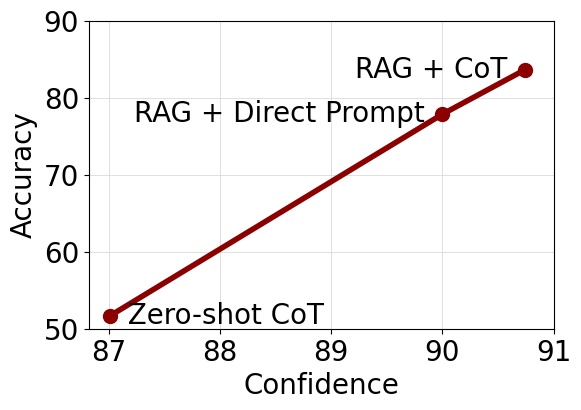

In [ ]:
#plot a line graph of confidence vs. accuracy_coarse, with each point labeled with the corresponding model_id.
fig = plt.figure(figsize=(6,4), )
ax = fig.add_subplot()
plt.plot(results_summary['confidence'], results_summary['accuracy_coarse'], c='darkred',linewidth=4, zorder=2)
plt.scatter(results_summary['confidence'], results_summary['accuracy_coarse'], s=100, c='darkred',zorder=3)
for i, txt in enumerate(results_summary['model_id']):
    if 'Zero' in txt:
        plt.annotate('  '+txt, (results_summary['confidence'].iloc[i], results_summary['accuracy_coarse'].iloc[i]),
                     ha='left', va='center', fontsize=20)
    else:
        plt.annotate(txt+'  ', (results_summary['confidence'].iloc[i], results_summary['accuracy_coarse'].iloc[i]),
                     ha='right', va='center', fontsize=20)
# set size of tick labels
plt.grid(color='lightgray', linewidth=0.5, axis='both', zorder=0)
# ax.set_xlim((85,95))
plt.xticks(list(range(87,92)),fontsize=20)
# ax.set_ylim((50,90))
plt.yticks(list(range(50,91,10)), fontsize=20)
plt.xlabel('Confidence', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.savefig('confidence_vs_accuracy.png', dpi=300,bbox_inches='tight')

#### Which system performed best?

![results dataframe](figures/results.png)

On classification accuracy, the n-gram heuristic models were the best on this dataset.

However, as a tool to empower instructors to make informed decisions (whether or not they decide to bring up an academic honesty citation), our system is much more useful than the heuristic models, as the reasoning trace from the CoT report can be used as meaningful, verifiable evidence about the student work, not just a single number. 

Additionally, our tool is more scalable (to larger, dynamic source corpuses), more adaptable (to different types of texts and novel modes of plagiarism), and more customizeable (to instructor preferences and plagiarism criteria).

## Demo

In [ ]:
plagiarism_classifier = Plagiarism_Classifier(embed_model, top_k,
                                                #   chunk_size,
                                                  llm, least_brazen_prompt,
                                                  f_ground=True, f_a_rel=True, f_c_rel=True, verbose=True)
suspect_text = input("What text would you like to check?")
report, feedback = plagiarism_classifier.classify_plagiarism(suspect_text)
print('Plagiarism Report:')
print(report)
print('RAG Trio Feedback:')
print(feedback)

NameError: name 'Plagiarism_Classifier' is not defined